<h2><center>Introduction </center></h2>

This is a little notebook that has a single initial intention: that of  showing the process of optimization in a Neural Network (NN) from the perspective of mass shuffling. In the future I will investigate other scenarios too.

First we import some libraries

In [1]:
import numpy as np
import tensorflow as tf

#from tensorflow.python.framework import ops

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits import mplot3d
import seaborn as sns
sns.set(style="darkgrid")

<h2><center> 1 - Creating some data </h2></center>

The problem lies in the category of supervised learning: we have a sample of elements of type $(X_i,Y_i)$, for $1 \leq i \leq N$, all independent and identically distributed, and we would like to train a predictor.


Let's start by generating a sample $X_i$, which will be normally distributed.

In [2]:
N = 1000
X = 10*np.random.randn(2,N)

With regards to the label Y, we are going to use the following classifier: 
    
    $ Y=1$  whenever $x_1 \geq 0$,  $Y=0$ otherwise.

In [3]:
Y = np.array((X[0,:]>=0),np.int32)

Let's count how many of each we have:


In [4]:
print(np.sum(Y), Y.shape)

467 (1000,)


which is more or less half of the sample.

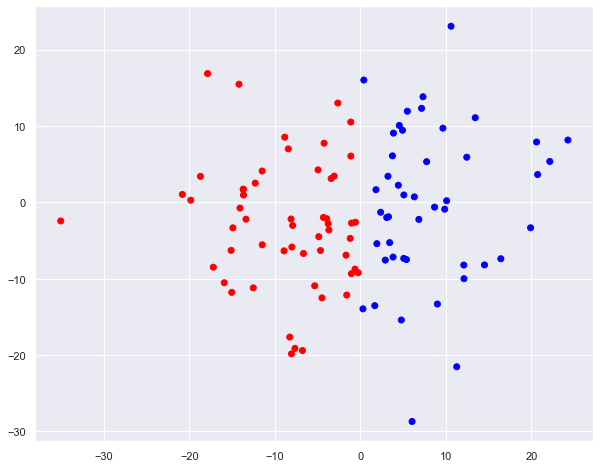

In [5]:
colors =['red','blue']
vec_color = [colors[i] for i in Y[:]]
plt.figure(figsize=(10,8))
plt.scatter(X[0,:100],X[1,:100],color=vec_color[:100])

<h3>1.1 -  Augmenting the dimension </h3>

I would like to make the dimension of this problem a bit higher. The ith element in our sample has coordinates X[i,:], and so far it is in $\mathbb{R}^2$; we shall consider this as a set of points lying on an embedded, 2 dimensional, manifold in a higher dimensional space.


In [6]:
additional_dimension = 13
Additional_dimension_coordinates = np.zeros([additional_dimension,N])

In [7]:
X = np.concatenate((X,Additional_dimension_coordinates),axis=0)

Just to check the dimensions, X should now have dimension $(2+13)\times N$

In [8]:
X.shape

(15, 1000)

which is indeed the case. In these "extra dimensions" we would like to add some small noise. The idea is that, as  we collect data, these  entries play the role of irrelevant features (but we didn't know that at the time of data gathering! How could we?!).

In [9]:
X[2:,:] = .01*np.random.randn(additional_dimension,N)

For instance, if we plot the first 3 dimensions, we will see that most of the points are clustered around the plane $(x_1,x_2)$ defined by the first two coordinates

<Figure size 432x288 with 0 Axes>

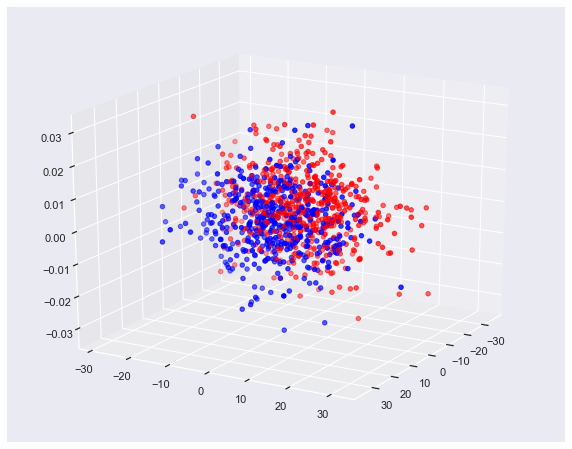

In [10]:
fig = plt.figure()
plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(X[0,:1000],X[1,:1000],X[2,:1000],color=vec_color[:1000]);
ax.view_init(20, 30)

Note the difference in magnitude of all the x,y axis to the z axis. We can make this difference visualy more pronounced if we plot everythin with the same scale:

<Figure size 432x288 with 0 Axes>

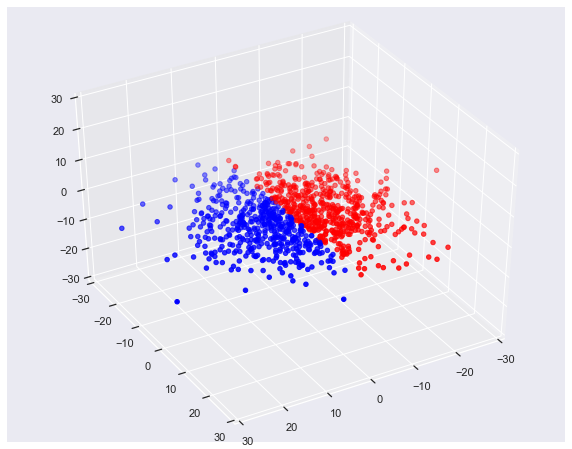

In [11]:
fig = plt.figure()
plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

ax.scatter3D(X[0,:1000],X[1,:1000],X[2,:1000],color=vec_color[:1000]);
ax.set_xlim3d(-30, 30)
ax.set_ylim3d(-30, 30)
ax.set_zlim3d(-30, 30)

ax.view_init(40, 60)  # This sets the angle by which we rotate the axis

<h3> 1.2 - Constructing a training and a test set  </h3>

We would like to set part of the sample apart so that it can be used for testing the model. However, we would like to have a stratified sample: both training, test, and CV set should have more or less the same proportion of $Y=1$ and $Y=0$

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split_sample= StratifiedShuffleSplit(n_splits=1, test_size=.2)

for train_index, test_index in split_sample.split(np.transpose(X),np.transpose(Y)):
    X_train,Y_train = X[:,train_index],np.reshape(Y[train_index],(1,-1))
    X_test,Y_test = X[:,test_index],np.reshape(Y[test_index],(1,-1))  

>__Just a quick remark on the above computation:__ note that we are using a strange "transpose" on X and Y to do the "split_sample.split(,). That's the case because the arguments for this function are of type 
       X : array-like, shape (n_samples, n_features)
       (see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html)
That's not a big deal though: as the output is an array of integers, we can use i in the columns. That's why we don't use the transpose when we assign X_train, Y_train and so.

Let's count the proportion in each group:


In [13]:
print("Proportion of elements in whole sample is: ",str(np.sum(Y)/len(Y))+"\n")
print("Proportion of elements in train set is: ", str(np.sum(Y_train)/Y_train.shape[1])+"\n")
print("Proportion of elements in test set is: ", str(np.sum(Y_test)/Y_test.shape[1]))

Proportion of elements in whole sample is:  0.467

Proportion of elements in train set is:  0.4675

Proportion of elements in test set is:  0.465


<h3>1.3 - Visualizing mass shuffle</h3>

One thing that we would like to do is vizualizing entries in a matrix as colors. Higher values will be redded, lower, more negative values, will have a colder value.



[[0.48476252 0.34550478 0.54460021 0.2460338  0.66292761]
 [0.53447239 0.86646543 0.76368555 0.00767189 0.42999264]
 [0.98304474 0.45872573 0.91924365 0.35856625 0.43997758]
 [0.71775006 0.68744951 0.06954802 0.45188963 0.87539893]
 [0.22460292 0.70602693 0.03025972 0.75933301 0.46396242]]


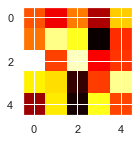

In [14]:
M = np.random.rand(5,5)
print(M)
fig, ax = plt.subplots(figsize=(2,2))
ax.imshow(M,cmap='hot')

<h2><center>2 - Training a simple logit regression </h2></center>

In the process of training a log regression I would like to see how the mass gets reshuffled in the weigh matrix. The model goes like this: denote the sigmoid function by $\sigma(\cdot)$, which we write as

$$ \sigma(z) = \frac{1}{1 + \exp(z)}, \quad z\in \mathbb{R}.$$

In our case we are going to use the following: we are interested in finding a vector $W \in $\mathbb{R}^{k}$ and a quantity $b\in \mathbb{R}$ that will be used in our predictor. To be more precise, we will have

$$ \hat{Y} = \left\{\begin{array}{ccc}
1, &if &\quad \quad \sigma(W\cdot X + b) \geq \eta\\
0 , &if &\quad \quad \sigma(W\cdot X + b) < \eta
\end{array}\right..$$

In fact, we know that $W = e_1 = (1, 0, 0, \ldots, 0)$ is the predictor that we are looking for. So, as we train our model we would like to see the entries $W_i$ (weights) in the matrix W to decay to 0 for $i\geq 2$ and converge to a positive number for $W_1$.

It is not hard to do this training using scilearn-kit, but this is not what we want: we want to go old school on this, so we are going to design the method by ourselves. 

Let's first create some auxiliary functions.

>__Remark:__ in the code you will see no $\eta$. That's because the tensorflow.round automatically sets $\eta =.5$. This function was used as a matter of convenience, and it is not hard to change it to the general case, that includes $\eta$ as parameter.

<h3>2.1 - Auxiliary functions </h3>

First we design a weigh initializer. Afterwards we design a forward propagation.


Note that we will keep k as a variable, for we want to study the effect of dimensionality in the model. So, to begin with we get a numpy vector with the number of nodes in each layer. This is going to be the vector "nodes_per_layer". Note that the number of nodes in the ith column will be given by "nodes_per_layer[i]"

In [15]:
k = 2 + additional_dimension
nodes_per_layer = np.array([k,1],ndmin=1)

Now we can initialize the weights that will connect the layers. Note that, from the perspective we want to study here, the "mass" will flow throught "pipes" that have weights given by the matrices W


In [16]:
def weight_initializer(nodes_per_layer):
    '''
    Initialize the matrix W with dimensions 1xk and the 1x1 parameter b
    '''
    L = len(nodes_per_layer)
    W, b = {},{}
    
    for i in range(1,L):
        W[str(i)] = tf.get_variable("W"+str(i),[nodes_per_layer[i],nodes_per_layer[i-1]],initializer=tf.contrib.layers.xavier_initializer())
        b[str(i)] = tf.get_variable("b"+str(i),[nodes_per_layer[i],1],initializer=tf.zeros_initializer())
    
    parameters = (W,b)
    return parameters

Let's test it

In [17]:
tf.reset_default_graph() 
W,b = weight_initializer(nodes_per_layer)
print(W)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
{'1': <tf.Variable 'W1:0' shape=(1, 15) dtype=float32_ref>}


The next thing that we need to do is a propagator. For tris we will receive a tuple with strings, whose entries describe the activation function in that layer. What we have is the following:

$$Z[i] = W[i]\cdot A[i-1] + b[i]$$

where $A[i-1]$ denotes the output of the previous layer. Note that the dimensions math: A[i-1] has dimension $n_{i-1}\times 1$, while W[i] has dimensions $n_{i}\times n_{i-1}$, hence Z[i] is a vector of dimensions $n_{i}\times 1$.

Before we write the propagation function, we are going to set the activation function vector:

In [18]:
type_activation = ['sigmoid']

In [19]:
def propagator(parameters,type_activation,X_tensor):
    L = len(type_activation)
    W, b = parameters
    A = X_tensor
    for i in range(L):
        if type_activation[i]=='relu':
            Z = tf.add(tf.matmul(W[str(i+1)],A),b[str(i+1)])
            if i !=L-1:
                Z = tf.nn.relu(Z)
        elif type_activation[i]=='sigmoid':
            Z = tf.add(tf.matmul(W[str(i+1)],A),b[str(i+1)])
            if i !=L-1:
                Z = tf.nn.sigmoid(Z)
    return Z

Do you see the big difference in the last propagation? That happens because in the last layer we don't need an activation function. This is due to the structure of the cross entropy function as implemented in tensorflow. In this link they say that: [https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits]

Well... so let's compute the loss function:

In [20]:
tf.reset_default_graph()
def cost_function(Z,Y):
    cost= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Z,labels=Y))
   
    return cost

In [21]:
tf.reset_default_graph()
with tf.Session() as sess:
    
    X_tensor = tf.placeholder(shape =[k,None],name='X',dtype=tf.float32)
    Y = tf.placeholder(shape=[1,None],name='Y',dtype=tf.float32)    
    parameters =weight_initializer(nodes_per_layer)
    Z = propagator(parameters,type_activation,X_tensor)

    print(cost_function(Z,Y))

Tensor("Mean:0", shape=(), dtype=float32)


Now we run the model. Let's first set some parameters for the search:



In [22]:
optimization_parameters={
    'learning_rate':0.0001,
    'epochs':30000,
    'printing':True
}

ntwk_settings={
    'number_nodes':nodes_per_layer,
    'activation_type':type_activation
}

And now we draw the model and run the data through it

In [23]:
def full_model(optimization_parameters,ntwk_settings,X_train,Y_train,X_test,Y_test):
    
    ## Unpacking
    nodes_per_layer = ntwk_settings['number_nodes']  ## Recall, this is a dimension k x 1 matrix
    type_activation = ntwk_settings['activation_type']
    learning_rate = optimization_parameters['learning_rate']
    epochs = optimization_parameters['epochs']
    printing = optimization_parameters['printing']
    
    tf.reset_default_graph()
    # first we create placeholders: they are the ones that will get the data
    k = nodes_per_layer[0]
    X_tensor= tf.placeholder(dtype=tf.float32,shape=[k,None]) 
    Y_tensor= tf.placeholder(dtype=tf.float32,shape=[1,None])
    
    # Now we define the weights
    parameters = weight_initializer(nodes_per_layer)
    W,b = parameters
    Z = propagator(parameters,type_activation,X_tensor)
    
    # And we finally compute the cost. This is the function that will be minimized
    cost= cost_function(Z,Y_tensor)
    
    ## Now we set up an optimizer
    optimizer_type = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    objective_function= optimizer_type.minimize(cost)
    
    '''
    Ok, so the above part only set up the graph over which we will compute things. You can see the graph as a 
    pipeline, that tells you where things are put in, combined, and where we get outputs 
    (that is, where we open the "faucet")
    '''
    # Below, we start running data throw these pipes! Let's do it.
    #For bookkeeping purposes, let's define two auxiliary quantities
    total_cost = []  #array that will save the cost values
    W_movie = []     #array that will save the weights for a movie
    
    initialize= tf.global_variables_initializer()
    
    with tf.Session() as sess:
        ## Initialize the nodes
        sess.run(initialize)
        
        for i in range(epochs):
            _,cost_now = sess.run([objective_function,cost],feed_dict={X_tensor:X_train[:k,:],Y_tensor:Y_train})

            if i%1000 ==0 and printing:
                print("\n Cost at "+str(i)+"th iterate: "+str(cost_now))
            if i%40 == 0:
                total_cost.append(cost_now)
                W_movie.append(sess.run(W["1"]))
        
        # Now we stack the matrices with respect to last coordinate in order to create a video with them later on
        Movie = np.stack(W_movie,2)
        
        if printing:
            plt.figure(figsize=(15,7))
            plt.plot(total_cost)
            plt.xlabel('Number of iterations',size=22)
            plt.ylabel('Cost',size=22)
            plt.title('Cost decay per iteration')
            plt.grid(True)
            plt.show()
        
        ### At this point we get the value of the optimized parameter and use it to make a prediction
        param = sess.run(parameters)
        
        # Prediction
        predicted_classification = tf.round(tf.sigmoid(Z))
        accuracy_of_prediction= tf.reduce_mean(tf.cast(tf.equal(predicted_classification,Y_tensor),"float"))

        ## Now we do some statistics:
        accuracy_train = sess.run(accuracy_of_prediction,feed_dict={X_tensor:X_train[:k,:],Y_tensor:Y_train})
        if printing:       print("Accuracy of training:", accuracy_train)
        accuracy_test = sess.run(accuracy_of_prediction,feed_dict={X_tensor:X_test[:k,:],Y_tensor:Y_test})
        if printing: print("Accuracy of test/validation:", accuracy_test)
    
    return (total_cost, accuracy_train,accuracy_test, Movie)



 Cost at 0th iterate: 4.3329387

 Cost at 1000th iterate: 3.4253223

 Cost at 2000th iterate: 2.5442781

 Cost at 3000th iterate: 1.718967

 Cost at 4000th iterate: 1.024744

 Cost at 5000th iterate: 0.5893747

 Cost at 6000th iterate: 0.40491867

 Cost at 7000th iterate: 0.31554875

 Cost at 8000th iterate: 0.25768864

 Cost at 9000th iterate: 0.21581575

 Cost at 10000th iterate: 0.18390281

 Cost at 11000th iterate: 0.15878399

 Cost at 12000th iterate: 0.13858381

 Cost at 13000th iterate: 0.12209348

 Cost at 14000th iterate: 0.108478755

 Cost at 15000th iterate: 0.09713336

 Cost at 16000th iterate: 0.0876004

 Cost at 17000th iterate: 0.0795272

 Cost at 18000th iterate: 0.0726378

 Cost at 19000th iterate: 0.06671402

 Cost at 20000th iterate: 0.061582662

 Cost at 21000th iterate: 0.057105456

 Cost at 22000th iterate: 0.05317184

 Cost at 23000th iterate: 0.049692594

 Cost at 24000th iterate: 0.046595518

 Cost at 25000th iterate: 0.043822154

 Cost at 26000th iterate: 0.0

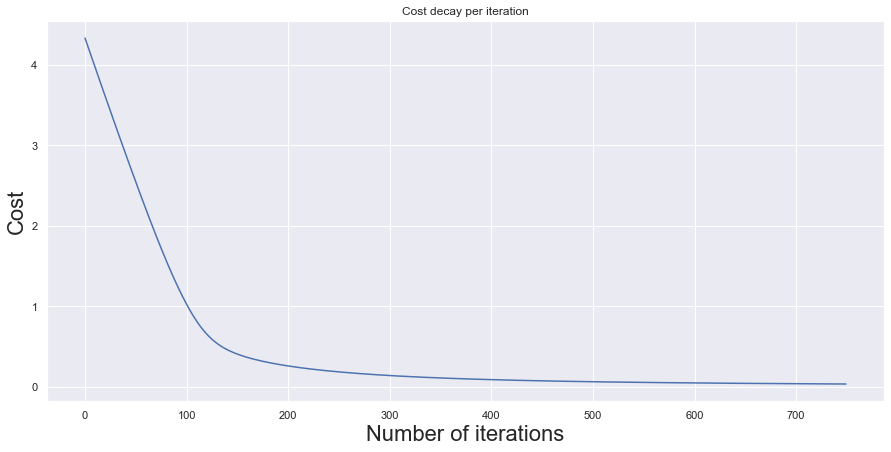

Accuracy of training: 1.0
Accuracy of test/validation: 0.995


In [24]:
_,_,_,Movie= full_model(optimization_parameters,ntwk_settings,X_train,Y_train,X_test,Y_test)

<h3> 2.2 - Visualizing mass shuffle and dynamic behavior of weights </h3>

Let's create a video with the weights in order to see how they evolve through time, that is, iterations:

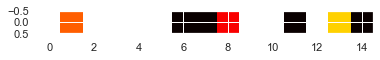

In [25]:
import time
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.animation as animation

global Movie

# Initialize the animation plot
fig = plt.gcf()

def updatefig(i):
    im = plt.imshow(Movie[:,:,i],cmap=plt.get_cmap('hot'),interpolation='nearest',vmin=-1,vmax=1)
    return im,

frames = np.shape(Movie)[-1]
ani = animation.FuncAnimation(fig, updatefig, interval=25, frames=frames,blit=True)
ani.save('NN_shallow.mp4')


In [26]:
import io
import base64
from IPython.display import HTML

video = io.open('NN_shallow.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

>Remark: recall that we are visualizing what is happening in the first layer.

Let's analize this video more carefully: it seems that the weights on $W^{(1)}[i]$ for $i \geq 2$ are getting more negative through "time"(i.e., iterations) while $W^{(1)}[0]$ is getting bigger. Let's plot it


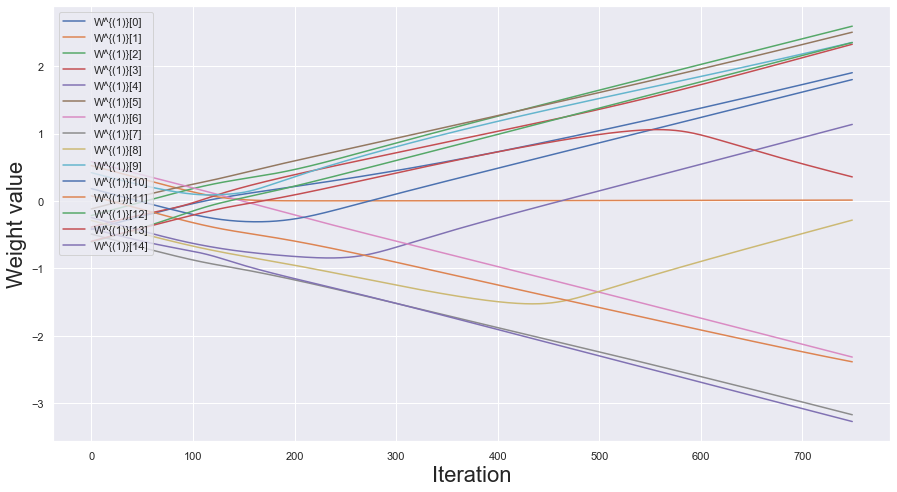

In [27]:
plt.figure(figsize=(15,8))

for i in range(k):
    plt.plot(Movie[0,i,:],label="W^{(1)}["+str(i)+"]")

plt.legend(loc=2)
plt.xlabel('Iteration',size=22)
plt.ylabel('Weight value',size=22)
plt.show()

Whaaaat?!! Why are the weights not getting separated??!! Yes, they are, but in AVERAGE!

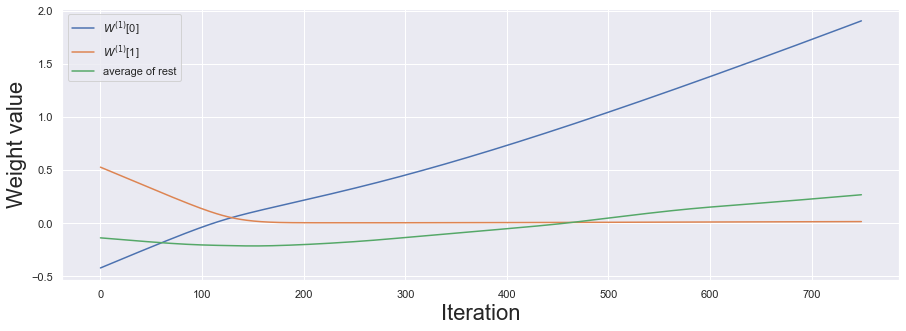

In [28]:
plt.figure(figsize=(15,5))

cop_Movie = np.copy(Movie)
v_0 = np.copy(Movie[0,0,:])
v_1 = np.copy(Movie[0,1,:])
cop_Movie[0,0,:]=0*Movie[0,0,:]
cop_Movie[0,1,:]=0*Movie[0,1,:]

plt.plot(v_0,label="$W^{(1)}$["+str(0)+"]")
plt.plot(v_1,label="$W^{(1)}$["+str(1)+"]")
plt.plot(np.squeeze(np.mean(cop_Movie,1)),label="average of rest")
plt.xlabel('Iteration',size=22)
plt.ylabel('Weight value',size=22)
plt.legend(loc=2)
plt.show()

Note that there is node that is a bit different from others: that's the first one! It is exactly the one responsible for capturing the behavior of the first coordinate. Further, note that in half of $Y=0$ or $Y=1$ cases one can expect the second coordinate to be either positive or negative, for it is normally distributed. The "best way" to avoid any issue with this coordinate is by "shutting it off": that's why we see it converging to zero. Curiously, the model does not turn off the weight on the other coordinates, showing that it gets affected by the noise we have added.

You can certainly do the same for larger NN, but the shallowest model is the best to see the effect of mass shuffling on the weights: as the video goes you start seeing less mass on the weights $W^{(i)}$ for $i\geq 1$. It is also possible to wonder what are the possible ways to shuffle mass in a NN, because backpropagation is one of them (indeed, a very effecient one!). We could also think of other methods, but let's not worry about that for these notes: I will  investigate that a bit further in future notebooks.

In [29]:
np.mean(Movie[:,:,[1,2]],1)

array([[-0.13295904, -0.13375863]], dtype=float32)

In [30]:
Movie_averaged= np.zeros([1,3,Movie.shape[-1]]) 
Movie_averaged[0,0,:] = Movie[0,0,:]
Movie_averaged[0,1,:] = Movie[0,1,:]
Movie_averaged[0,2,:] = np.mean(Movie[0,2:,:],0)

(1, 3, 750)

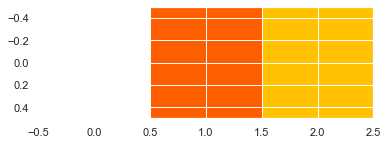

In [31]:
global Movie_averaged

fig = plt.gcf()

def updatefig(i):
    im = plt.imshow(Movie_averaged[:,:,i],cmap=plt.get_cmap('hot'),interpolation='nearest',vmin=-1,vmax=1)
    return im,

frames = np.shape(Movie_averaged)[-1]
ani = animation.FuncAnimation(fig, updatefig, interval=25, frames=frames,blit=True)
ani.save('NN_shallow_averaged.mp4')

In [32]:
video = io.open('NN_shallow_averaged.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

<h2><center> 3- Non linear prediction boundaries </center></h2>

The boundary between classes in the previous model was linear, thus one could exepect a good performance of even a shallow NN (a logit model is the simplest possible NN you can imagine). But let's see what happens if we change the boundary a bit. By doing so we also bring in the second coordinate, making it "slightly" relevant fot the prediction, but not that much: on average, the model still "separates well" with a simple linear boundary.

In [33]:
N = 400
X = 10*np.random.randn(2,N)
Y = np.array((X[0,:]>=5*np.sin(X[1,:])),np.int32)

additional_dimension =13
Additional_dimension_coordinates = np.zeros([additional_dimension,N])
X = np.concatenate((X,Additional_dimension_coordinates),axis=0)
X[2:,:] = .1*np.random.randn(additional_dimension,N)

split_sample= StratifiedShuffleSplit(n_splits=1, test_size=.2)

for train_index, test_index in split_sample.split(np.transpose(X),np.transpose(Y)):
    X_train,Y_train = X[:,train_index],np.reshape(Y[train_index],(1,-1))
    X_test,Y_test = X[:,test_index],np.reshape(Y[test_index],(1,-1))  

<Figure size 432x288 with 0 Axes>

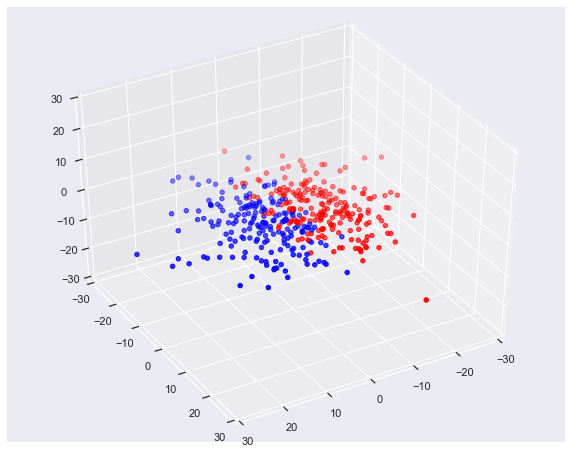

In [34]:
fig = plt.figure()
plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
colors =['red','blue']
vec_color = [colors[i] for i in Y[:]]

ax.scatter3D(X[0,:1000],X[1,:1000],X[2,:1000],color=vec_color[:1000]);
ax.set_xlim3d(-30, 30)
ax.set_ylim3d(-30, 30)
ax.set_zlim3d(-30, 30)

ax.view_init(40, 60)  # This sets the angle by which we rotate the axis

In [35]:
optimization_parameters={
    'learning_rate':0.0001,
    'epochs':10000,
    'printing':True
}

k = 2 + additional_dimension
nodes_per_layer = np.array([k,1],ndmin=1)

type_activation = ['sigmoid']
ntwk_settings={
    'number_nodes':nodes_per_layer,
    'activation_type':type_activation
}


 Cost at 0th iterate: 1.3417832

 Cost at 1000th iterate: 0.79833853

 Cost at 2000th iterate: 0.47583246

 Cost at 3000th iterate: 0.32199946

 Cost at 4000th iterate: 0.2611546

 Cost at 5000th iterate: 0.23907354

 Cost at 6000th iterate: 0.23003292

 Cost at 7000th iterate: 0.22525847

 Cost at 8000th iterate: 0.22249818

 Cost at 9000th iterate: 0.2209907


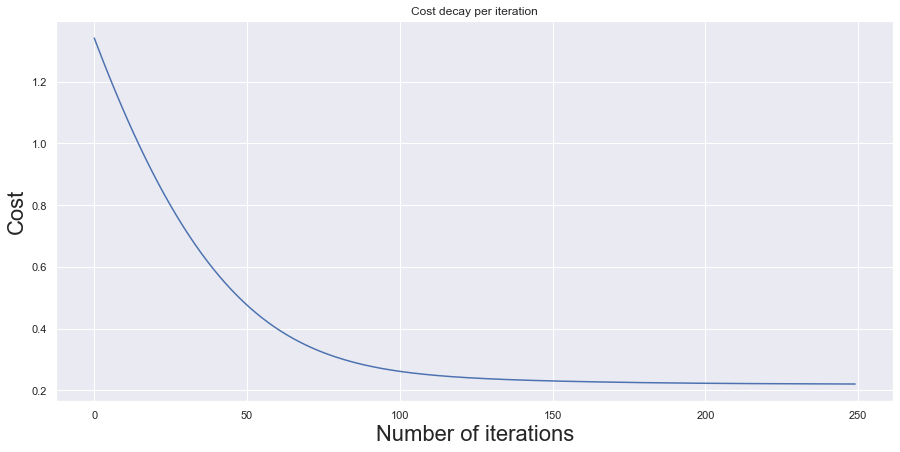

Accuracy of training: 0.890625
Accuracy of test/validation: 0.85


In [36]:
_,_,_,Movie= full_model(optimization_parameters,ntwk_settings,X_train,Y_train,X_test,Y_test)

It is clear that the accuracy of the model has decayed, in both the training and in the test set.

As before, let's plot the dynamic behavior of the weights

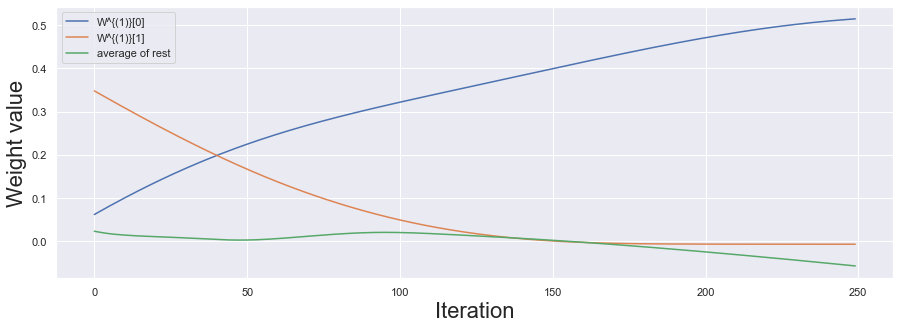

In [37]:
plt.figure(figsize=(15,5))

cop_Movie = np.copy(Movie)
v_0 = np.copy(Movie[0,0,:])
v_1 = np.copy(Movie[0,1,:])
cop_Movie[0,0,:]=0*Movie[0,0,:]
cop_Movie[0,1,:]=0*Movie[0,1,:]

plt.plot(v_0,label="W^{(1)}["+str(0)+"]")
plt.plot(v_1,label="W^{(1)}["+str(1)+"]")
plt.plot(np.squeeze(np.mean(cop_Movie,1)),label="average of rest")
plt.xlabel('Iteration',size=22)
plt.ylabel('Weight value',size=22)
plt.legend(loc=2)
plt.show()